# Hypothesis testing - continued

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

custom_palette = sns.color_palette('viridis', 2)
sns.set_palette(custom_palette)

Let's use our sample of movies to perform hypothesis testing in two ways: model of the world and confidence interval. 

Say that someone claims that the IMDB score given to each movie is a completely random number drawn between 1 (minimum) and 10 (maximum). This then implies that the average score should be 5.5.

$H_{0}$: Since IMDB scores of movies are random, the mean score in the population is 5.5.<br>
$H_{1}$: No, scores are not random, and the mean score is different than 5.5.

In [2]:
movies_df = pd.read_csv('movie_metadata.csv')
display(movies_df.describe())
sample_size = movies_df.shape[0]
print(sample_size)

,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,budget,title_year,imdb_score,movie_facebook_likes
count,3881.000000,3882.000000,3.882000e+03,3.882000e+03,3882.000000,3.882000e+03,3882.000000,3882.000000,3882.000000
mean,109.886369,781.218444,5.114833e+07,1.026713e+05,11281.888717,3.872725e+07,2003.082174,6.462107,9149.570582
std,22.724192,3019.868885,6.984633e+07,1.508444e+05,18941.023800,4.792372e+07,10.007686,1.056180,21324.775147
min,34.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,2.180000e+02,1920.000000,1.600000,0.000000
25%,95.000000,10.000000,6.855627e+06,1.732350e+04,1825.500000,1.000000e+07,1999.000000,5.900000,0.000000
50%,106.000000,58.000000,2.805488e+07,5.040200e+04,3896.500000,2.400000e+07,2005.000000,6.600000,207.500000
75%,120.000000,225.000000,6.548808e+07,1.242370e+05,16006.250000,5.000000e+07,2010.000000,7.200000,11000.000000
max,330.000000,23000.000000,7.605058e+08,1.689764e+06,656730.000000,7.000000e+08,2016.000000,9.300000,349000.000000


3882


The p-value is 0.0


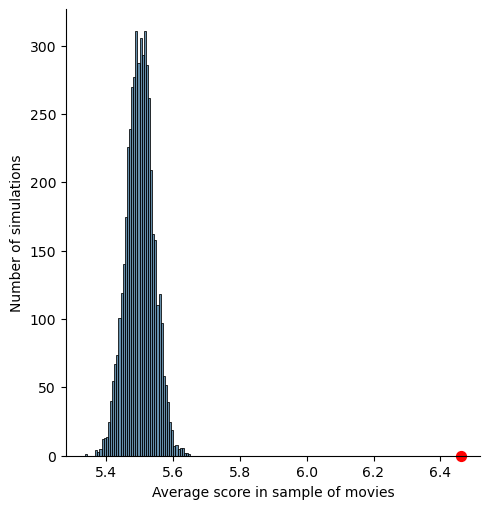

In [3]:
def simulate_imdb_scores():
    random_scores = np.random.uniform(1, 10, size=sample_size)
    mean_score = random_scores.mean()
    return mean_score

# run multiple simulations
num_sims = 5000
many_mean_scores = np.empty(num_sims)
for i in range(num_sims):
    many_mean_scores[i] = simulate_imdb_scores()
    
many_mean_scores
# Compute p-value
observed_stat = movies_df['imdb_score'].mean() #get value of test statistic from data
num_samples_with_stat_we_got_or_less = np.count_nonzero(many_mean_scores >= observed_stat)
print('The p-value is', num_samples_with_stat_we_got_or_less/num_sims)

# visualizing the results
ax = sns.displot(many_mean_scores)
ax.set(xlabel='Average score in sample of movies', ylabel='Number of simulations')
plt.scatter(observed_stat, 0, marker='.', s=200, color='red', clip_on=False);

Actually, since our alternative hypothesis is **two-sided** (the average is either higher or lower than 5.5), we should have also added all cases in which the simulations showed us more extreme values in the other direction: smaller than the hypothetical value of a test statistic that would be "as small as our actual test statistic is big" (relative to $H_{0}$). Hence, here, we would also add up all simulations in which the mean scores were lower than 5.5-(6.46-5.5) = 4.54. Of course, in this case there were no such simulations, so the p-value does not change.

What is the conclusion?

Now, let's create a 95% confidence interval for the mean IMDB score in the population and check the same hypotheses again. What do you expect would happen? Will the CI include 5.5? What if we create a 99% confidence interval? 

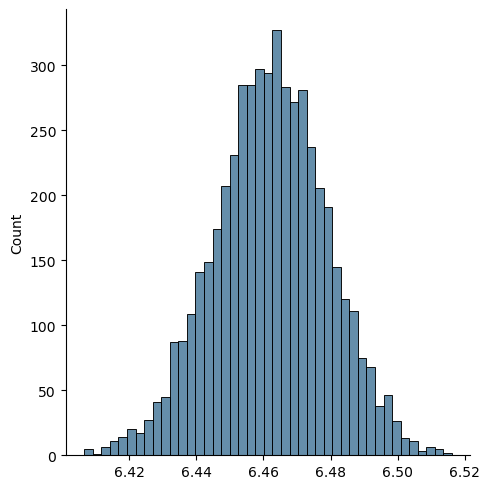

In [4]:
def bootstrap_mean(original_sample, column_name, num_replications):
    '''This function returns an array of bootstrapped sample averages:
    original_sample: df containing the original sample
    column_name: name of column containing the variable of interest
    num_replications: number of bootstrap samples'''
    original_sample_size = original_sample.shape[0] 
    original_sample_var_of_interest = original_sample[[column_name]]
    bstrap_means = np.empty(num_replications)
    for i in range(num_replications):
        bootstrap_sample = original_sample_var_of_interest.sample(original_sample_size, replace=True) # note WITH REPLACEMENT!
        resampled_mean = bootstrap_sample.mean()
        bstrap_means[i] = resampled_mean
    
    return bstrap_means

means_bootstrapped = bootstrap_mean(movies_df, 'imdb_score', 5000)
ax=sns.displot(means_bootstrapped)

The 95% boostsrap confidence interval for population mean is [6.428799587841319, 6.494693456980938]


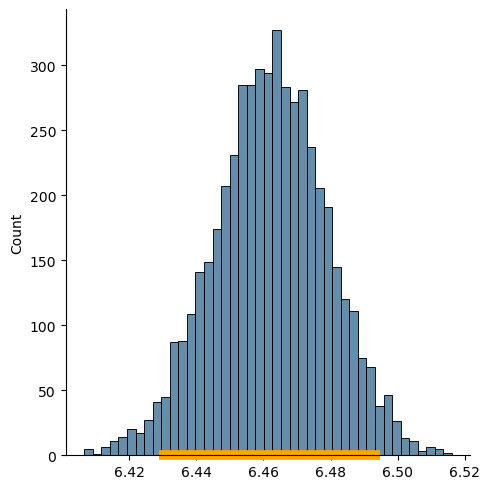

In [5]:
# Get the endpoints of the 95% confidence interval
left_end = np.percentile(means_bootstrapped, 2.5, method='higher')
right_end = np.percentile(means_bootstrapped, 97.5, method='higher')
print('The 95% boostsrap confidence interval for population mean is', [left_end,right_end])

# visualize results
ax = sns.displot(means_bootstrapped)
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False);  # show line of values between 10 and 90 percentiles

### Comparison of groups

So far we only tested hypotheses regarding a single random sample. Often, we would like to compare two random samples to one another. Specifically, we may be interested in knowing if a certain value associated with each of two random samples is the same or are the samples different with respect to that value (this is also sometimes called A/B testing).

As an example, let's check whether there is a difference in the gross income of drama and comedy movies. 


In [6]:
# create a dataframe of comedy and drama movies
drama_comedy_df = movies_df[(movies_df['genres'] == 'Drama') | (movies_df['genres'] == 'Comedy')]
drama_comedy_df.head()

,color,director_name,duration,director_facebook_likes,gross,genres,movie_title,num_voted_users,cast_total_facebook_likes,budget,title_year,imdb_score,movie_facebook_likes
25,Color,James Cameron,194.0,0,658672302,Drama,Titanic,793059,45223,200000000,1997,7.7,26000
49,Color,Baz Luhrmann,143.0,1000,144812796,Drama,The Great Gatsby,362912,29770,105000000,2013,7.3,115000
72,Color,Tom Shadyac,96.0,293,100289690,Comedy,Evan Almighty,115099,108016,175000000,2007,5.4,2000
97,Color,David Fincher,166.0,21000,127490802,Drama,The Curious Case of Benjamin Button,459346,13333,150000000,2008,7.8,23000
113,Color,Francis Lawrence,104.0,508,256386216,Drama,I Am Legend,530870,13076,150000000,2007,7.2,11000


First, let's visualize the means of these two groups:

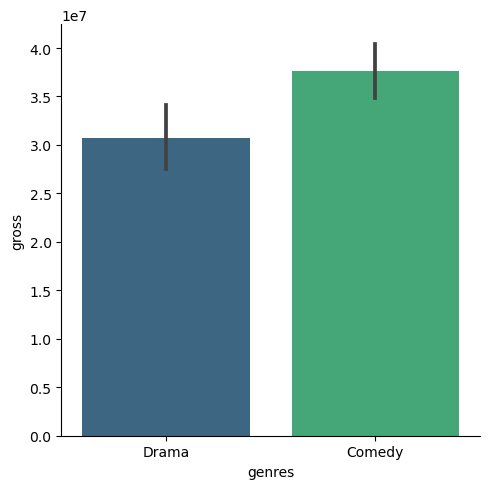

In [7]:
sns.catplot(data=drama_comedy_df, x='genres', y='gross', kind='bar')

So, there is a difference in the averages between the two genres in the sample, but is this difference just due to chance, or is it evidence of a more systamatic difference in the means of the population?

First, let's formulate our hypotheses:

$H_{0}$: The mean gross income of drama movies is equal to the mean gross income of comedy movies<br>
$H_{1}$: The mean gross income of drama movies is **not** equal to the mean gross income of comedy movies

(question: why did we formulate the hypotheses this way and not the other way around?)

We can use the same process of hypothesis testing through confidence intervals to do this. 

To test the hypothesis, we can construct a confidence interval for the **difference between the means** of gross income of drama and comedy movies. That is, the parameter we are interested is the **difference between the means** of drama and comedy movies in the entire population. <br>
We only have a sample of movies, from which we can construct a confidence interval to estimate the difference in means, with high probability. 

*Thought exercise:* What values of the confidence interval will cause us to reject the null hypothesis?

In [8]:
# function that returns the difference in averages
def diff_of_avgs(df, column_name, grouping_var):
    grpby_var = df.groupby(grouping_var)
    avgs = grpby_var[column_name].mean()
#     return avgs.loc['Drama'] - avgs.loc['Comedy']  
    return avgs[1] - avgs[0]

def bootstrap_mean_difference(original_sample, column_name, grouping_var, num_replications):
    '''This function returns an array of bootstrapped differences between two sample averages:
      original_sample: df containing the original sample
      column_name: name of column containing the variable to average
      grouping_var: name of variable according to which to group
      num_replications: number of bootstrap samples'''
    original_sample_size = original_sample.shape[0] # we need to replicate with the same sample size
    original_sample_cols_of_interest = original_sample[[column_name, grouping_var]]
    bstrap_mean_diffs = np.empty(num_replications)
    for i in range(num_replications):
        bootstrap_sample = original_sample_cols_of_interest.sample(original_sample_size, replace=True) # note WITH REPLACEMENT!
        resampled_mean_diff = diff_of_avgs(bootstrap_sample, column_name, grouping_var)
        bstrap_mean_diffs[i] = resampled_mean_diff
    
    return bstrap_mean_diffs

# run the bootstrap procedure
bstrap_diffs = bootstrap_mean_difference(drama_comedy_df, 'gross', 'genres',  5000)

The 95% boostsrap confidence interval for difference between population means [-11287009.330757178, -2286840.6086514443]


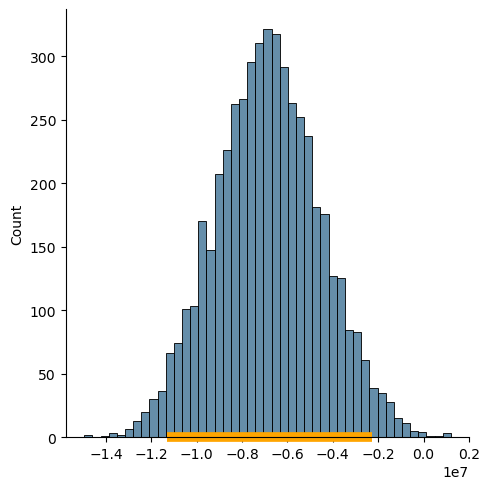

In [9]:
# Get the endpoints of the 95% confidence interval
left_end = np.percentile(bstrap_diffs, 2.5, method='higher')
right_end = np.percentile(bstrap_diffs, 97.5, method='higher')
print('The 95% boostsrap confidence interval for difference between population means', [left_end,right_end])

# visualize results
ax = sns.displot(bstrap_diffs)
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False);  # show line of values between 2.5 and 97.5 percentiles

Zero is not included in the 95% CI for the difference between the means, and therefore we reject the null hypothesis and conclude at the 95% confidence level that the there is a difference between the mean gross income of comedy movies and drama movies.

Note that we actually got a more useful result than just saying "the difference is not zero": We have an **estimate of what this difference is**.

#### Another example
We can now compare other features of the two groups we defined. For example, let's compare imdb_score. 
First, visualize the difference:

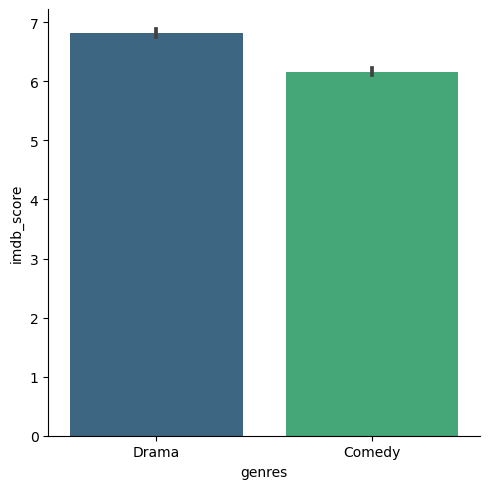

In [10]:
sns.catplot(data=drama_comedy_df, x='genres', y='imdb_score', kind="bar")

##### Exercise
Test the hypothesis that the average imdb_score for drama movies is different than the average number of director Facebook likes for comedy movies. **Use 0.01 as significance level.**

## Multiple categories
Previosuly, we tested hypotheses for continuous variables (as above) or for the proportion of a single category (e.g. proportion of black jurors). We can also look at the distribution of multiple categories and test hypotheses for this case. This will require a distance measure that compares probability distributions.

### Jury Selection in Alameda County
In 2010, the American Civil Liberties Union (ACLU) of Northern California presented a report on jury selection in Alameda County, California. The report concluded that certain ethnic groups are underrepresented among jury panelists in Alameda County, and suggested some reforms of the process by which eligible jurors are assigned to panels. We will perform our own analysis of the data and examine some questions that arise as a result.

Let's look at the data below.

In [11]:
jury_panel_df = pd.DataFrame({'Ethnicity': ['Asian', 'Black', 'Latino', 'White', 'Other'], 
                              'Eligible Jury': [0.15, 0.18, 0.12, 0.54, 0.01], 
                              'Jury Panels': [0.26, 0.08, 0.08, 0.54, 0.04]
                             })

# reshape df to get the value of interest, proportion, on the same column (tidy up the data)
jury_panel_df_reshaped = pd.melt(jury_panel_df, id_vars="Ethnicity", var_name="Population", value_name="Proportion")
jury_panel_df_reshaped


,Ethnicity,Population,Proportion
0,Asian,Eligible Jury,0.15
1,Black,Eligible Jury,0.18
2,Latino,Eligible Jury,0.12
3,White,Eligible Jury,0.54
4,Other,Eligible Jury,0.01
5,Asian,Jury Panels,0.26
6,Black,Jury Panels,0.08
7,Latino,Jury Panels,0.08
8,White,Jury Panels,0.54
9,Other,Jury Panels,0.04


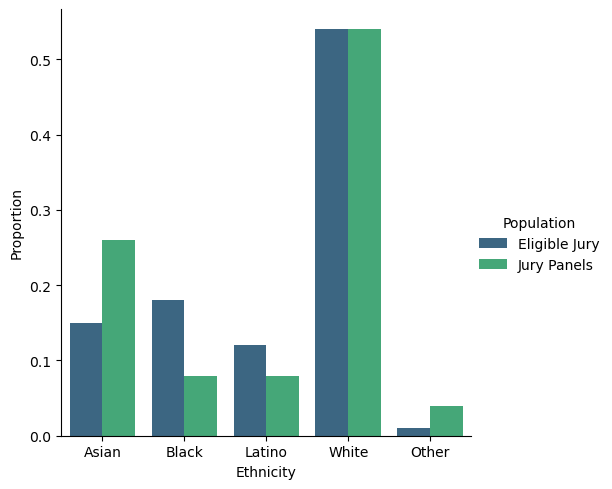

In [12]:
# visualize distributions
ax = sns.catplot(kind="bar", x='Ethnicity', y='Proportion', hue='Population', data=jury_panel_df_reshaped)

To assess whether the panels are chosen at random (without biasing based on ethnic groups), we will need a statistic that compares *distributions*. 

There are many distance metrics for distributions, we will use a simple measure, called "total variation distance" (https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures). 
This is how we compute total variation distance:
- For each category, compute the difference in proportions between two distributions
- Take the absolute value of each difference
- Sum, and then divide the sum by 2

For example, in the jury case, the distance between the distribution of ethnic groups in the population and in the panels is:
$(|0.15-0.26| + |0.18-0.08| + |0.12-0.08| + |0.54-0.54| + |0.01-0.04|)/2 = 0.14$

Let's make sure we got this right:

In [13]:
population_groups = ['Asian', 'Black', 'Latino', 'White', 'Other']
population_dist = [0.15, 0.18, 0.12, 0.54, 0.01] # distribution of eligible jurors
panels_dist = [0.26, 0.08, 0.08, 0.54, 0.04] # distribution in jury panels

# function for computing total variation distance
def compute_tvd(sample1_vals, sample2_vals):
    return (np.sum(np.absolute(sample1_vals - sample2_vals)))/2

tvd_aclu = compute_tvd(np.array(population_dist), np.array(panels_dist))
tvd_aclu

0.14

We can now simulate random jury panels of size 1453 (sample size of the ACLU data) based on their distribution in the population, and check the total variation distance between the values we get and the distribution in the population. Then, we can see whether a distance of 0.14 is reasonable given our model.

First, let's write a code to simulate one value of the statistic, under the null:

In [14]:
# function for simulating one value of the statistic under the null
sample_size = 1453
def simulate_jury_distance():
    # first, draw a simple random sample under the null
    jury_sample = np.random.choice(population_groups, p=population_dist, size=sample_size)
    # second, count the number of elements of each group
    jury_sample_group_counts = []
    for group in population_groups:
        jury_sample_group_counts.append(np.count_nonzero(jury_sample == group))
    # third, get the proportions in the sample
    proportions_in_sample = np.divide(jury_sample_group_counts, sample_size)
    # finally, get TVD between sample and theoretical distribution
    distance = compute_tvd(np.array(population_dist), proportions_in_sample)
    return distance

simulate_jury_distance()

0.019745354439091554

Now, let's get an empirical distribution of the test statistic:

In [15]:
# running many simulations
num_repetitions = 10000
many_tvds = np.empty(num_repetitions)
for i in range(num_repetitions):
    many_tvds[i] = simulate_jury_distance()
    
many_tvds

array([0.00445974, 0.02203716, 0.02282175, ..., 0.01205093, 0.00901583,
       0.01438403])

Finally, let's compare visually between the distribution of TVDs and the test statistic we got, and compute the p-value

The p-value is 0.0


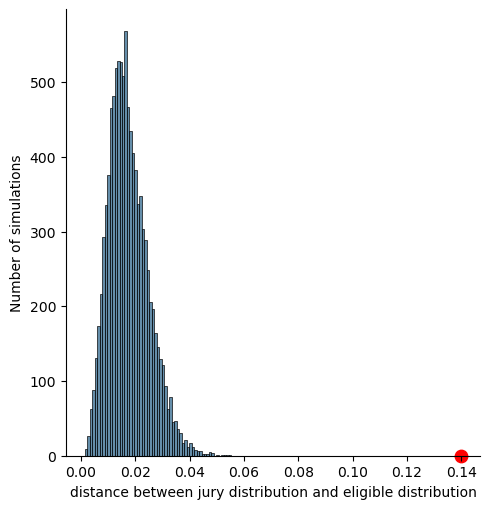

In [16]:
# visualizing the results
ax = sns.displot(many_tvds)
ax.set(xlabel='distance between jury distribution and eligible distribution', ylabel='Number of simulations')
plt.scatter(tvd_aclu, 0, color='red', s=80, clip_on=False); # shows red dot where the value of the test statistic is

num_samples_with_tvd_as_we_got_or_more = np.count_nonzero(many_tvds >= tvd_aclu)
print ('The p-value is', num_samples_with_tvd_as_we_got_or_more/num_repetitions)

What is the conclusion?